In [1]:
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
from utils import *
from utils.GridWorldPeriodicTerminal import GridWorldPeriodicTerminal, PeriodicRewardState
from utils.GridWorldPitfalls import GridWorldWithPitfalls
from tqdm import tqdm
import cv2

# Q-Learning: Off Policy TD Control
$$ Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha \left[ R_{t+1} + \gamma \max_a Q(S_{t+1}, a) - Q(S_t, A_t) \right] $$
对未来action-value的估计，直接取决于下一步的最优action-value。在Sarsa中，我们是先根据policy选出了新的action，然后当前action-value的估计是取决于这个新action的value，也因此Sarsa是on-policy的。而Q-Learning没有根据policy选新的action，而是直接greedy地根据最优action-value更新参数，因此Q-Learning是off-policy的。

Q-Learning要比Sarsa和接下来的Expected-Sarsa在决策上更加激进，由于它在估计action-value的时候使用了下一个state-action的最大value，而完全不会考虑下一个state-action也可能有其他的很坏的action。比如一条近路周围都是陷阱，另一条远路很安全，那么Q-Learning会选择近路，因为路周围的陷阱导致对于一些a,$Q(S_{t+1}, a)$很小，但又因为路很近，导致某个$Q(S_{t+1}, a)$ 很大，Q-Learning的公式就注定了它看不到这些陷阱带来的可能的危险，而只能看到这条路是最近的。Sarsa不同，由于它在估计action-value的时候使用的下一个action-value是由policy所指导的，因此在多次尝试之后其policy会很受陷阱的影响，导致这条路不会被选择。

Sarsa:  30%|███       | 3000/10000 [00:13<00:31, 223.28it/s]


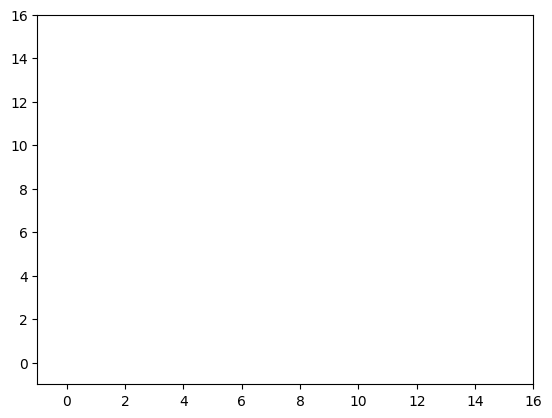

In [4]:
def QLearning(grid_world: GridWorldPeriodicTerminal):
    agent = Agent(grid_world, Policy(grid_world))
    # Make state value of terminal state
    agent.initTerminalValues(grid_world)
    gamma = 0.9
    step_size = 0.2

    for it in tqdm(range(10000), desc="QLearning"):
        # initialize eposide with non terminal state
        grid_world.reset(0)
        while grid_world.isTerminalState(grid_world.start_sid):
            grid_world.reset(0)  # reset with a random start state

        agent.policy = agent.action_value.copy(grid_world)
        agent.policy.normalize()

        old_sid = grid_world.current_sid

        while True:
            # random_action_id = np.random.randint(0, grid_world.n_actions)
            action_id = agent.takeAction(old_sid, epsilon=0.4)
            r = grid_world.step(action_id)
            new_sid = grid_world.current_sid

            # update state value
            agent.state_value[old_sid] += step_size * (r + gamma * agent.state_value[new_sid] - agent.state_value[old_sid])

            if grid_world.isTerminalState(grid_world.current_sid):
                ### --- Action value for terminal state --- ###
                agent.action_value[old_sid, action_id] += step_size * (r - agent.action_value[old_sid, action_id])
                break

            # take new action
            # new_aid = agent.takeAction(new_sid, epsilon=0.4)

            # update action value
            agent.action_value[old_sid, action_id] += step_size * (r + gamma * np.max(agent.action_value[new_sid]) - agent.action_value[old_sid, action_id])

            old_sid = new_sid

        # update terminal state reward
        if PeriodicRewardState.reward_changed:
            for sid in grid_world.getTerminalStateIds():
                agent.state_value[sid] = grid_world.states[sid].getReward()
            PeriodicRewardState.reward_changed = False

        if it % 100 == 0:
            agent.policy.normalize()
            img = grid_world.render(agent, figsize=(10, 10))
            cv2.imshow("img", img)
            k = cv2.waitKey(1)
            if k == ord("q"):
                break
    cv2.destroyAllWindows()

QLearning(GridWorldPeriodicTerminal(world_size=16, 
                        win_states=[(10, 2), (4, 10), (14, 14)], 
                        fail_states=[(4, 4), (6, 6), (10, 10), (12, 12)]
                        )
    )

In [13]:
def QLearning(grid_world: GridWorldWithPitfalls):
    agent = Agent(grid_world, Policy(grid_world))
    # Make state value of terminal state
    agent.initTerminalValues(grid_world)
    gamma = 0.8
    step_size = 0.1

    for it in tqdm(range(6000), desc="QLearning"):
        # initialize eposide with non terminal state
        grid_world.reset(10)
        while grid_world.isTerminalState(grid_world.start_sid):
            grid_world.reset(10)  # reset with a random start state

        agent.policy = agent.action_value.copy(grid_world)
        agent.policy.normalize()

        old_sid = grid_world.current_sid

        while True:
            # random_action_id = np.random.randint(0, grid_world.n_actions)
            action_id = agent.takeAction(old_sid, epsilon=0.4)
            r = grid_world.step(action_id)
            new_sid = grid_world.current_sid

            # update state value
            agent.state_value[old_sid] += step_size * (r + gamma * agent.state_value[new_sid] - agent.state_value[old_sid])

            if grid_world.isTerminalState(grid_world.current_sid):
                ### --- Action value for terminal state --- ###
                agent.action_value[old_sid, action_id] += step_size * (r - agent.action_value[old_sid, action_id])
                break

            # take new action
            # new_aid = agent.takeAction(new_sid, epsilon=0.4)

            # update action value
            agent.action_value[old_sid, action_id] += step_size * (r + gamma * np.max(agent.action_value[new_sid]) - agent.action_value[old_sid, action_id])

            old_sid = new_sid

    grid_world.reset(10)
    for sid in grid_world.getNonTerminalStateIds():
        best_action_id = agent.action_value[sid].argmax()
        agent.policy[sid] = 0
        agent.policy[sid, best_action_id] = 1

    # Run another time to get path
    grid_world.reset(10)
    while not grid_world.isTerminalState(grid_world.current_sid):
        action_id = agent.takeAction(grid_world.current_sid, epsilon=0)
        grid_world.step(action_id)

    grid_world.render(agent, figsize=(10, 10))
    plt.show()

QLearning: 100%|██████████| 6000/6000 [00:05<00:00, 1021.46it/s]


111 [(1, 2), (1, 3), (1, 4), (1, 5), (1, 6)]


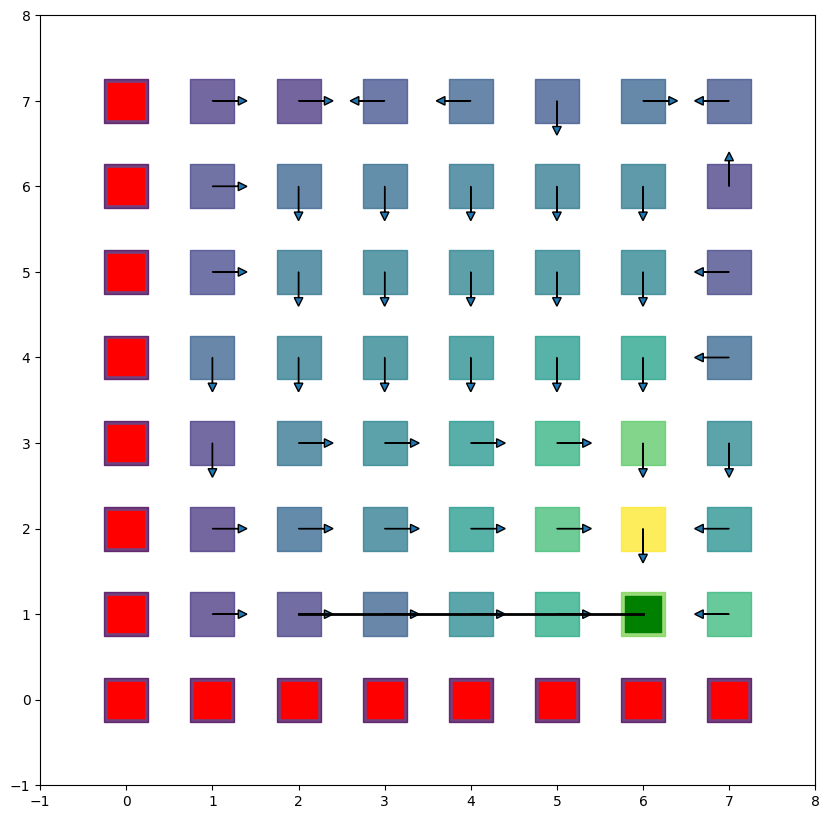

In [15]:
QLearning(GridWorldWithPitfalls(world_size=8, 
                            win_states=[(1, 6)], 
                            fail_states=[(0, i) for i in range(8)] + [(i, 0) for i in range(8)]))